In [9]:
#Read in trajectory file
import numpy as np
import matplotlib.pyplot as plt
import json

servoIndices = {
    "NeckTilt": 0,
    "NeckPan": 1,
    "LeftEye": 2,
    "RightEye": 3,
    "LeftPupil": 4,
    "RightPupil": 5,
    "LeftArmJoint1": 6,
    "LeftArmJoint2": 7,
    "LeftArmJoint3": 8,
    "LeftArmJoint4": 9,
    "LeftArmJoint5": 10,
    "LeftHand": 11,
    "RightArmJoint1": 12,
    "RightArmJoint2": 13,
    "RightArmJoint3": 14,
    "RightArmJoint4": 15,
    "RightArmJoint5": 16,
    "RightHand": 17,
    "Body": 18
}

def read_traj_json(file):
    with open(file) as f:
        data = json.load(f)
    trajectories = {traj['UniqueID']: parse_traj(traj['Trajectory']) for traj in data['Trajectories']}
    currents = {traj['UniqueID']: parse_traj(traj['Current']) for traj in data['Trajectories']}
    return trajectories, currents

def parse_traj(traj):
    return np.abs(np.array(traj))

def plot_one_servo_traj(dict, metrics, servo, datatype="Position", plots_per_row=4, filter=None, *filter_args):
    traj_ids = list(dict.keys())

    if filter:
        traj_ids = [traj_id for traj_id in traj_ids if filter(metrics, traj_id, servo, *filter_args)]
        if not traj_ids:
            print(f"No trajectories found for {servo} with the active filter")
            return
    
    n_row = (len(traj_ids) + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed
    
    # Adjust figsize based on the number of rows and plots per row
    fig, axs = plt.subplots(n_row, plots_per_row, figsize=(plots_per_row * 4, n_row * 4))
    
    
    axs = axs.flatten()  # Flatten the array of axes for easy iteration
    fig.suptitle(f'{servo} {datatype} Trajectories')
    
    for i, traj_id in enumerate(traj_ids):
        data = dict[traj_id]
        axs[i].plot(data[:, servoIndices[servo]])
        if (datatype == "Position"):
            axs[i].plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'bo', label='Starting Position')
            axs[i].plot(len(data), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
        axs[i].set_title(f'ID: {traj_id}')
        
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    plt.legend()
    
    plt.tight_layout()
    plt.show()

## read in metrics from CurrentPositionMapping.json as dictionary
def mapping_metrics_to_dic(file_path):
    # Read the JSON file
    with open(file_path, 'r') as file:
        data = json.load(file)
    
    # Create a dictionary to store the results
    result = {}
    
    # Iterate through each mapping in the JSON data
    for mapping in data['Mapping']:
        # Extract the UniqueID (assuming it's always a list with one element)
        unique_id = mapping['UniqueID'][0]
        
        # Create a dictionary for this mapping, excluding the UniqueID
        mapping_dict = {key: value for key, value in mapping.items() if key != 'UniqueID'}
        
        # Add this mapping to the result dictionary, using the UniqueID as the key
        result[unique_id] = mapping_dict
    
    return result
#plot both current and position trajectories with twin y axis
def plot_one_servo_traj_with_current(pos_dict, current_dict, metrics, servo, plots_per_row=4, filter=None, *filter_args):
    traj_ids = list(pos_dict.keys())

    if filter:
        traj_ids = [traj_id for traj_id in traj_ids if filter(metrics, traj_id, servo, *filter_args)]
        if not traj_ids:
            print(f"No trajectories found for {servo} with the active filter")
            return
    
    n_row = (len(traj_ids) + plots_per_row - 1) // plots_per_row  # Calculate the number of rows needed
    
    # Adjust figsize based on the number of rows and plots per row
    fig, axs = plt.subplots(n_row, plots_per_row, figsize=(plots_per_row * 4, n_row * 4))
    
    axs = axs.flatten()  # Flatten the array of axes for easy iteration
    fig.suptitle(f'{servo} Position and Current Trajectories')
    #some distance between the title and the plots
    fig.subplots_adjust(top=0.92, hspace=0.4, wspace=0.4)
    
    for i, traj_id in enumerate(traj_ids):
        data = pos_dict[traj_id]
        axs[i].plot(data[:, servoIndices[servo]], label='Position')
        axs[i].plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'bo', label='Starting Position')
        axs[i].plot(len(data), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
        axs[i].set_title(f'ID: {traj_id}')
        if i % plots_per_row == 0:
            axs[i].set_ylabel('Position')
        axs[i].set_xlabel('Time')
        axs[i].tick_params(axis='y', colors='b')
        
        current_data = current_dict[traj_id]
        # Create a twin y-axis for the current data
        axs2 = axs[i].twinx()
        axs2.plot(current_data[:, servoIndices[servo]], 'r', label='Current')
        if (i + 1) % plots_per_row == 0:
            axs2.set_ylabel('Current')
        axs2.tick_params(axis='y', colors='r')
        
    # Hide any unused subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])
    plt.legend()
    
    plt.show()

def plot_one_trajectory(trajectories, metrics, traj_id, servo):
    traj = trajectories[traj_id]
    plt.plot(traj[:, servoIndices[servo]])
    plt.plot(0, metrics[traj_id]['StartingPosition'][servoIndices[servo]], 'ro', label='Starting Position')
    plt.plot(len(traj), metrics[traj_id]['GoalPosition'][servoIndices[servo]], 'go', label='Goal Position')
    plt.title(f'Trajectory: {traj_id}')
    plt.legend()
    plt.show()

def filter_by_overshot(dict, traj_id, servo):
    return dict[traj_id]['OvershotGoal'][servoIndices[servo]] == 1

def filter_by_start_position(dict, traj_id, servo, start):
    return abs(dict[traj_id]['StartingPosition'][servoIndices[servo]]-start) <= 10



In [10]:
# Read in trajectory json file
all_trajectories, all_currents = read_traj_json('TrajectoriesTorso.json')
mapping_metrics = mapping_metrics_to_dic('CurrentPositionMappingTorso.json')
num_trajectories_to_plot = 15

##Take the last 10 trajectories and make a dictionary of them
trajectories = {key: all_trajectories[key] for key in list(all_trajectories.keys())[-num_trajectories_to_plot:]}
currents = {key: all_currents[key] for key in list(all_currents.keys())[-num_trajectories_to_plot:]}

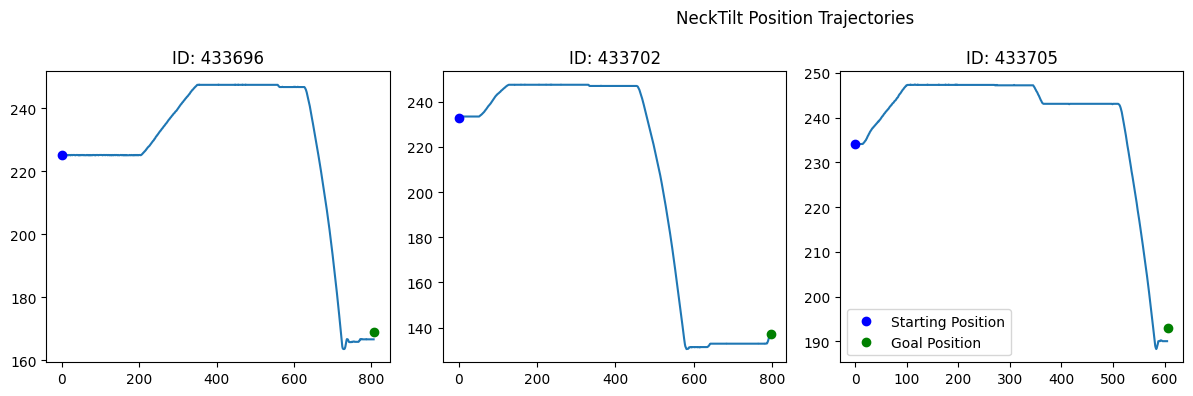

In [12]:
plot_one_servo_traj(all_trajectories, mapping_metrics, 'NeckTilt', "Position", 4, filter_by_start_position, 230)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


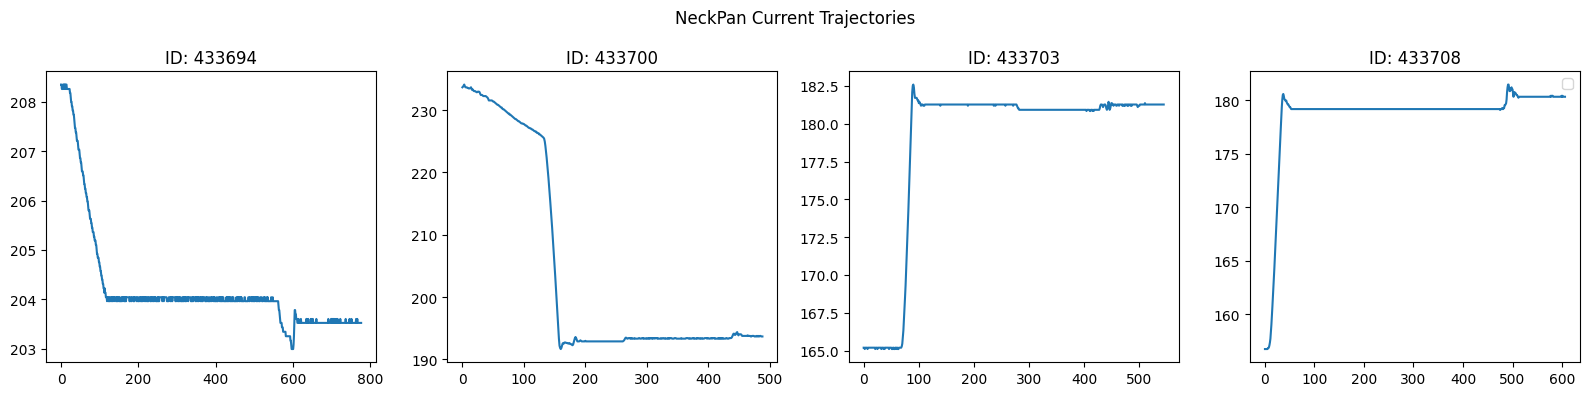

In [15]:
#NeckPan
plot_one_servo_traj(all_trajectories, mapping_metrics, 'NeckPan', "Current", 4, filter_by_overshot)

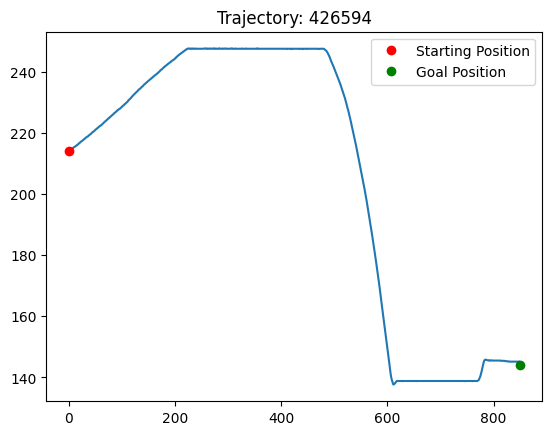

In [73]:
plot_one_trajectory(trajectories, mapping_metrics, 426594, 'NeckTilt')

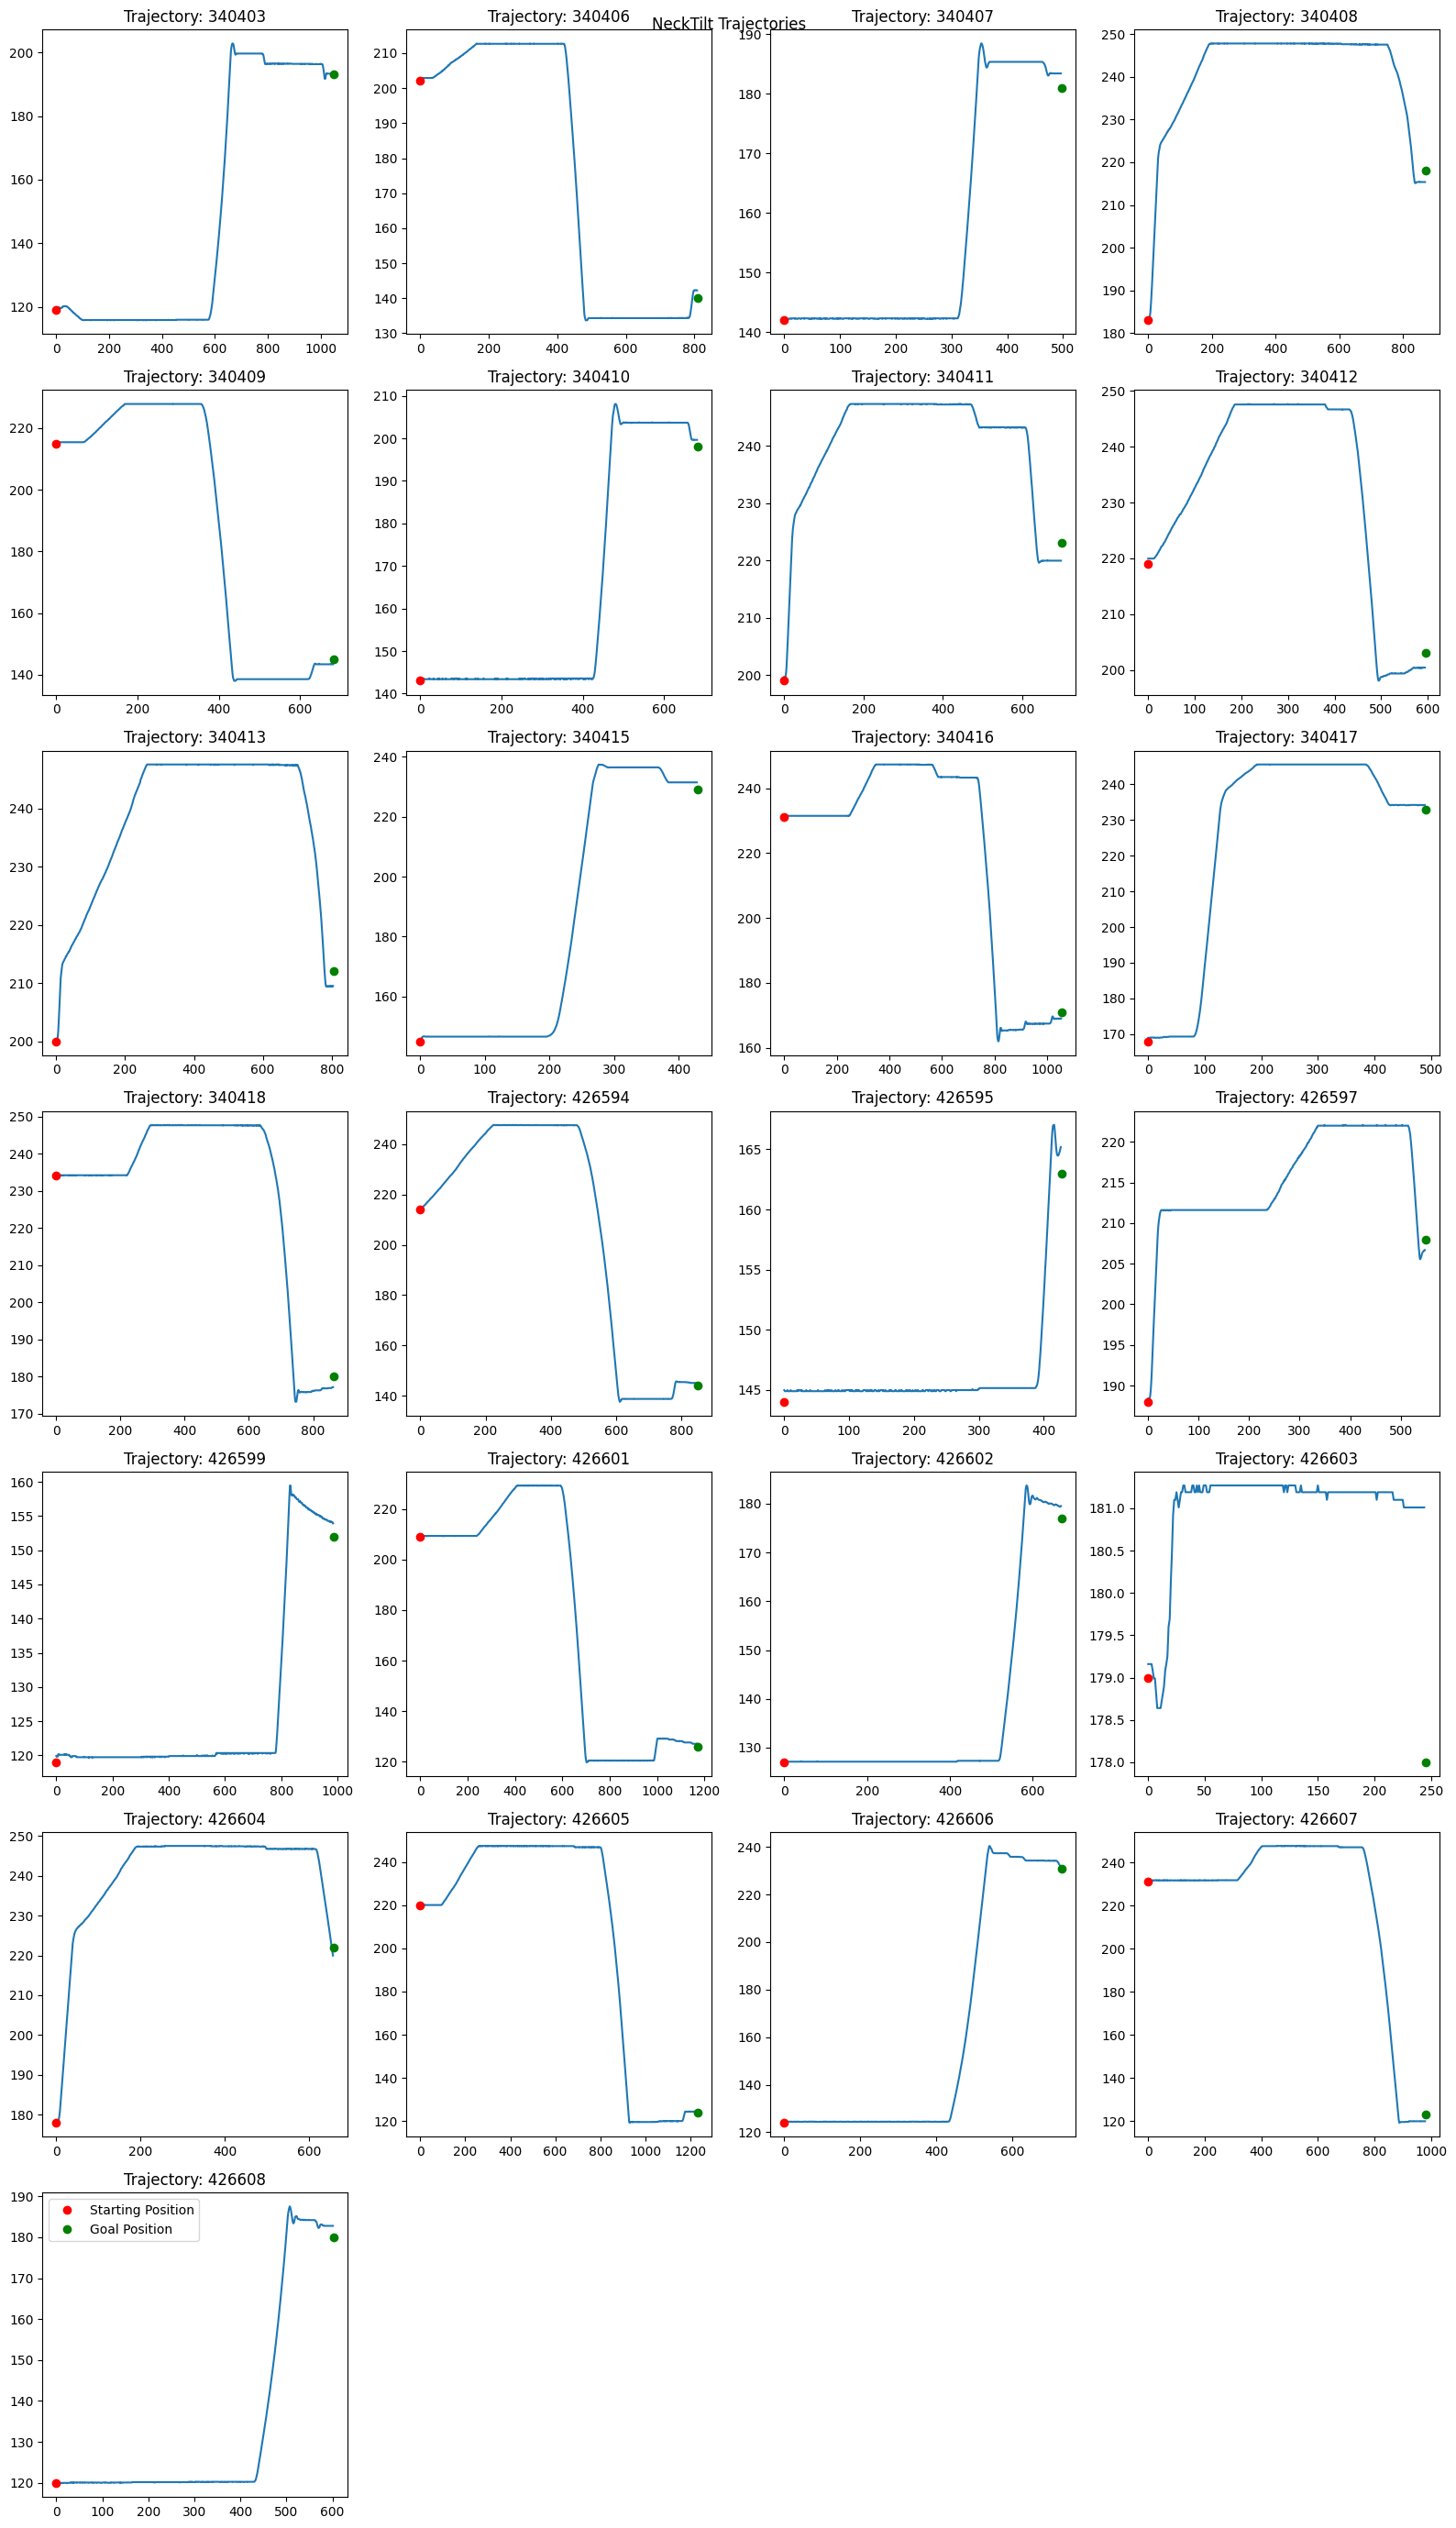

In [54]:
plot_one_servo_traj(all_trajectories, mapping_metrics, 'NeckTilt', 4, filter_by_overshot)

In [127]:
plot_one_servo_traj(trajectories, mapping_metrics, 'NeckPan', 4, filter_by_overshot)

No trajectories found for NeckPan with the active filter
